In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
import torchvision.transforms.functional as f
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os
import shutil
import random
from PIL import Image
from collections import defaultdict, Counter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: '{device}'")

Device in use: 'cuda'


# 0. Loading Images

In [3]:
dataset_path = "/kaggle/input/disaster-dataset-4class"

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageFolder(root=dataset_path, transform=transform)

print(f"Total Images: {len(dataset)}")

Total Images: 1946


In [4]:
class_names = dataset.classes
print(f"Class Available: {class_names}\n")

class_idx = dataset.class_to_idx
print(f"Class Index: {class_idx}\n")

class_counts = Counter(dataset.targets)
print(f"Class counts: {class_counts}\n")

print("--- Image Distribution ---")
for class_index, count in class_counts.items():
    class_name = class_names[class_index]
    print(f"{class_name} Class: {count} images")

Class Available: ['Earthquake', 'Land_Slide', 'Urban_Fire', 'Water_Disaster']

Class Index: {'Earthquake': 0, 'Land_Slide': 1, 'Urban_Fire': 2, 'Water_Disaster': 3}

Class counts: Counter({3: 1035, 1: 456, 2: 419, 0: 36})

--- Image Distribution ---
Earthquake Class: 36 images
Land_Slide Class: 456 images
Urban_Fire Class: 419 images
Water_Disaster Class: 1035 images


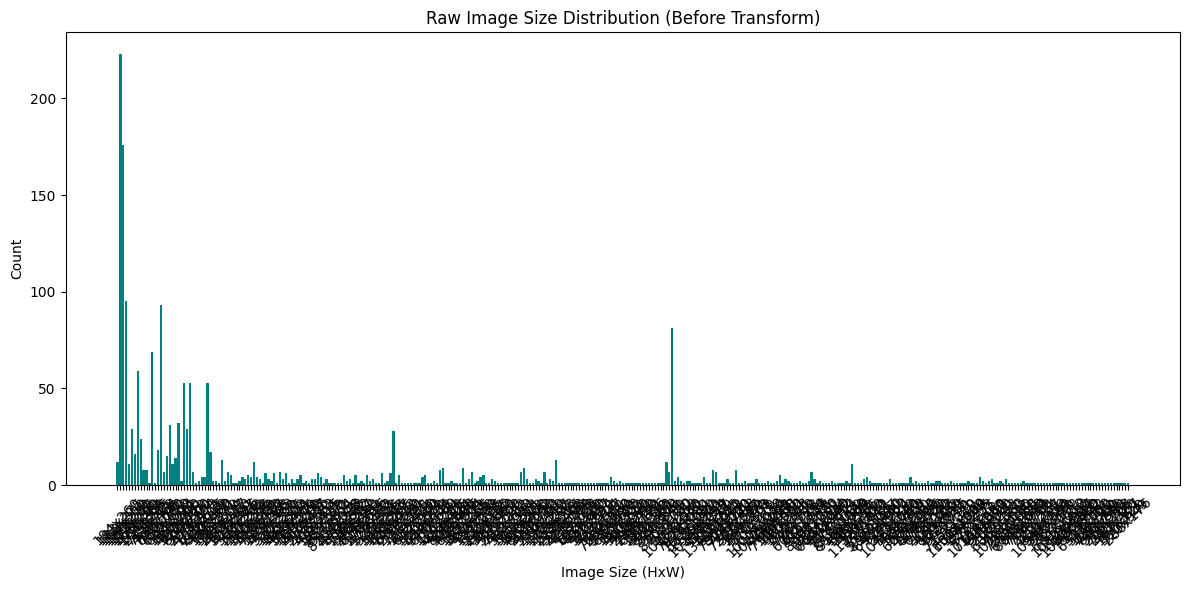

In [5]:
def show_image_size_distribution(dataset):
    size_counter = Counter()

    for img_path, _ in dataset.samples:
        try:
            img = Image.open(img_path)
            size = img.size  # (width, height)
            size_counter[size] += 1
            img.close()
        except Exception as e:
            print(f"Error reading {img_path}: {e}")

    size_labels = [f"{h}x{w}" for (w, h) in size_counter.keys()]
    size_counts = list(size_counter.values())

    plt.figure(figsize=(12, 6))
    plt.bar(size_labels, size_counts, color='teal')
    plt.xticks(rotation=45)
    plt.title("Raw Image Size Distribution (Before Transform)")
    plt.xlabel("Image Size (HxW)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

show_image_size_distribution(dataset)

In [6]:
image_sizes = []

for img_path, _ in dataset.samples:
    try:
        img = Image.open(img_path)
        size = img.size  # (width, height)
        area = size[0] * size[1]
        image_sizes.append((area, size, img_path))
        img.close()
    except Exception as e:
        print(f"Error reading {img_path}: {e}")

image_sizes.sort(key=lambda x: x[0])

print("3 Smallest Image Sizes:")
for area, size, path in image_sizes[:3]:
    print(f"Size: {size[1]}x{size[0]} (HxW), Area: {area}, Path: {path}")

print("\n3 Largest Image Sizes:")
for area, size, path in image_sizes[-3:]:
    print(f"Size: {size[1]}x{size[0]} (HxW), Area: {area}, Path: {path}")

3 Smallest Image Sizes:
Size: 157x220 (HxW), Area: 34540, Path: /kaggle/input/disaster-dataset-4class/Urban_Fire/Urban_Fire_image39.png
Size: 173x260 (HxW), Area: 44980, Path: /kaggle/input/disaster-dataset-4class/Water_Disaster/Water_Disaster_image120.png
Size: 132x380 (HxW), Area: 50160, Path: /kaggle/input/disaster-dataset-4class/Land_Slide/Land_Slide_image357.png

3 Largest Image Sizes:
Size: 1350x1080 (HxW), Area: 1458000, Path: /kaggle/input/disaster-dataset-4class/Water_Disaster/Water_Disaster_image908.png
Size: 1350x1080 (HxW), Area: 1458000, Path: /kaggle/input/disaster-dataset-4class/Water_Disaster/Water_Disaster_image925.png
Size: 820x2048 (HxW), Area: 1679360, Path: /kaggle/input/disaster-dataset-4class/Land_Slide/Land_Slide_image259.png


# 1. Splitting Data to Train, Validation, and Test Dataset (70%, 10%, 20%)

In [7]:
raw_dataset = ImageFolder(root=dataset_path, transform=transform)
image_label_list = [(img, label) for img, label in raw_dataset]

In [8]:
labels = [label for _, label in image_label_list]

train_val_data, test_data = train_test_split(image_label_list, test_size=0.2, stratify=labels, random_state=0)
train_data, val_data = train_test_split(train_val_data, test_size=0.125, stratify=[label for _, label in train_val_data], random_state=0)

len(train_data), len(val_data), len(test_data)

(1361, 195, 390)

In [9]:
train_data_percentage = (len(train_data)/len(raw_dataset))*100
val_data_percentage = (len(val_data)/len(raw_dataset))*100
test_data_percentage = (len(test_data)/len(raw_dataset))*100

print("--- After Splitting Percentage and Total ---\n")
print("-"*50)
print(f"Train Data Percentage: {np.round(train_data_percentage, 0)}\nTrain Data Total: {len(train_data)}")
print("-"*50)
print(f"Validation Data Percentage: {np.round(val_data_percentage, 0)}\nValidation Data Total: {len(val_data)}")
print("-"*50)
print(f"Test Data Percentage: {np.round(test_data_percentage, 0)}\nTest Data Total: {len(test_data)}")
print("-"*50)

--- After Splitting Percentage and Total ---

--------------------------------------------------
Train Data Percentage: 70.0
Train Data Total: 1361
--------------------------------------------------
Validation Data Percentage: 10.0
Validation Data Total: 195
--------------------------------------------------
Test Data Percentage: 20.0
Test Data Total: 390
--------------------------------------------------


# 2. Balancing Dataset

In [10]:
def undersample_oversample_data(data, class_names, undersampling=True, oversampling=True, augmentation=None):
    new_data = []
    label_counts = Counter([label for _, label in data])
    mean_count = np.round(np.mean(list(label_counts.values()))).astype(int)

    for cls in class_names:
        class_items = [(img, lbl) for img, lbl in data if lbl == cls]

        if label_counts[cls] > mean_count:
            # Undersampling with probabilites
            select_prob = (mean_count/label_counts[cls]) + 0.5
            for item in class_items:
                if undersampling:
                    if random.random() < select_prob:
                        new_data.append(item)
                else:
                    new_data.append(item)

        elif label_counts[cls] < mean_count:
            # Oversampling with augmentations
            if oversampling and augmentation:
                generate_number = int(mean_count/label_counts[cls])
                for item in class_items:
                    for _ in range(generate_number):
                        augmented_imgs = augmentation(item[0], item[1])
                        for img_aug in augmented_imgs:
                            new_data.append((img_aug, item[1]))
                    new_data.append(item) # Add original imgs
            else:
                new_data.extend(class_items)
        else:
            # If class is alread balanced
            new_data.extend(class_items)
    
    random.shuffle(new_data)
    return new_data

In [11]:
augmentation_fn = lambda img, label: [
    transforms.RandomHorizontalFlip()(img),
    transforms.RandomRotation(15)(img)
] 

In [12]:
class_names_idx = dataset.class_to_idx
class_names = class_names_idx.keys()
class_idx = class_names_idx.values()

print(f"Class Names: {class_names}\n")
print(f"Class Index: {class_idx}\n")

Class Names: dict_keys(['Earthquake', 'Land_Slide', 'Urban_Fire', 'Water_Disaster'])

Class Index: dict_values([0, 1, 2, 3])



In [13]:
train_data_new = undersample_oversample_data(train_data, class_idx, undersampling=True, oversampling=True, augmentation=augmentation_fn)

# 3. Define Image Augmentation

In [14]:
class SafeToTensor:
    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            return img
        return transforms.ToTensor()(img)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    SafeToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    SafeToTensor()
])

# 4. Custom Dataset Wrapper Build

In [15]:
class DisasterDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data = data_list
        self.transform = transform
        self.targets = [item[1] for item in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# 5. Dataset to Dataloader

In [16]:
train_dataset = DisasterDataset(train_data_new, transform=train_transform)
val_dataset = DisasterDataset(val_data, transform=val_test_transform)
test_dataset = DisasterDataset(test_data, transform=val_test_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
train_counts = Counter(train_dataset.targets)
val_counts = Counter(val_dataset.targets)
test_counts = Counter(test_dataset.targets)

print("--- Training Set Distribution ---")
print(train_counts)
print("\n--- Validation Set Distribution ---")
print(val_counts)
print("\n--- Test Set Distribution ---")
print(test_counts)

--- Training Set Distribution ---
Counter({1: 957, 2: 879, 3: 706, 0: 702})

--- Validation Set Distribution ---
Counter({3: 104, 1: 46, 2: 42, 0: 3})

--- Test Set Distribution ---
Counter({3: 208, 1: 91, 2: 84, 0: 7})


# 6. Visualize Sample Images

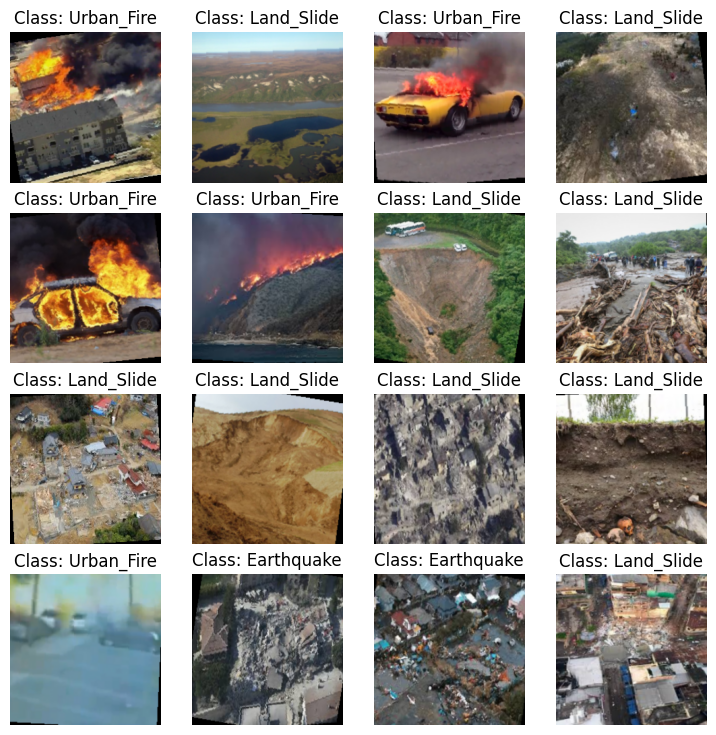

In [18]:
def show_images(dataset, ROWS=3, COLS=3):
    plt.figure(figsize=(9, 9))
    
    for i in range(1, ROWS*COLS+1):
        img, label = dataset[i]
        img = f.to_pil_image(img)

        plt.subplot(ROWS, COLS, i)
        plt.imshow(img)
        plt.title(f"Class: {list(class_names)[label]}")
        plt.axis('off')
    plt.show()

show_images(train_dataset, ROWS=4, COLS=4)

# 7. CNN Scratch Build

In [19]:
class CNNScratchModel(nn.Module):
    def __init__(self, 
                 input_shape: int,
                 output_shape: int,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=16, momentum=0.9),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=32, momentum=0.9),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*14*14,
                      out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,
                      out_features=output_shape),
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f'Output shape of conv_block_1: {x.shape}')
        x = self.conv_block_2(x)
        # print(f'Output shape of conv_block_2: {x.shape}')
        x = self.conv_block_3(x)
        # print(f'Output shape of conv_block_3: {x.shape}')
        x = self.conv_block_4(x)
        # print(f'Output shape of conv_block_4: {x.shape}')
        x = self.classifier(x)
        return x

In [20]:
NUM_CLASSES = len(class_names)

scratchModel = CNNScratchModel(input_shape=3, output_shape=NUM_CLASSES).to(device=device)
scratchModel

CNNScratchModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

In [21]:
summary(scratchModel, input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNNScratchModel                          [32, 4]                   --
├─Sequential: 1-1                        [32, 16, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 16, 224, 224]        448
│    └─BatchNorm2d: 2-2                  [32, 16, 224, 224]        32
│    └─ReLU: 2-3                         [32, 16, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 16, 112, 112]        --
├─Sequential: 1-2                        [32, 32, 56, 56]          --
│    └─Conv2d: 2-5                       [32, 32, 112, 112]        4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 112, 112]        64
│    └─ReLU: 2-7                         [32, 32, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 32, 56, 56]          --
├─Sequential: 1-3                        [32, 64, 28, 28]          --
│    └─Conv2d: 2-9                       [32, 64, 56, 56]          18,496
│    └─

# 8.  Define Optimizers, Loss and Evaluation Metrics

In [22]:
accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device=device)
precision = Precision(task="multiclass", num_classes=NUM_CLASSES, average="weighted").to(device=device)
recall = Recall(task="multiclass", num_classes=NUM_CLASSES, average="weighted").to(device=device)
f1score = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="weighted").to(device=device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(scratchModel.parameters(), lr=1e-3)

# 9. Training

## 9.1 Training Loop Build

In [23]:
def train_loop(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: optim,
               num_classes: int,
               device: torch.device = 'cpu'):
    accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes).to(device=device)
    precision_fn = Precision(task="multiclass", num_classes=num_classes, average="weighted").to(device=device)
    recall_fn = Recall(task="multiclass", num_classes=num_classes, average="weighted").to(device=device)
    f1score_fn = F1Score(task="multiclass", num_classes=num_classes, average="weighted").to(device=device)

    train_loss = 0
    train_accuracy = 0
    train_precision = 0
    train_recall = 0
    train_f1score = 0
    total_batches = len(dataloader)
    model.train()
    model = model.to(device)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        if isinstance(y_pred, tuple):
            y_pred = y_pred[0]
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        y_pred = y_pred.argmax(dim=1)
        
        train_accuracy += accuracy_fn(y, y_pred).item()
        train_precision += precision_fn(y, y_pred).item()
        train_recall += recall_fn(y, y_pred).item()
        train_f1score += f1score_fn(y, y_pred).item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= total_batches
    train_accuracy /= total_batches
    train_precision /= total_batches
    train_recall /= total_batches
    train_f1score /= total_batches

    print(f'Train loss: {train_loss:.5f} | Train Accuracy: {train_accuracy:.2f} | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1-Score: {train_f1score:.2f}')

    return train_accuracy, train_loss

## 9.2 Validation Function Build

In [24]:
def validate_model(model: nn.Module,
                   dataloader: DataLoader,
                   loss_fn: nn.Module,
                   num_classes: int,
                   device: torch.device = 'cpu'):
    accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes).to(device=device)
    precision_fn = Precision(task="multiclass", num_classes=num_classes, average="weighted").to(device=device)
    recall_fn = Recall(task="multiclass", num_classes=num_classes, average="weighted").to(device=device)
    f1score_fn = F1Score(task="multiclass", num_classes=num_classes, average="weighted").to(device=device)
    
    val_loss = 0
    val_accuracy = 0
    val_precision = 0
    val_recall = 0
    val_f1score = 0
    total_batches = len(dataloader)
    model.eval()
    model = model.to(device)
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            val_pred = model(X)
            if isinstance(val_pred, tuple):
                val_pred = val_pred[0]
            val_loss += loss_fn(val_pred, y)
            y_pred = val_pred.argmax(dim=1)

            val_accuracy += accuracy_fn(y, y_pred).item()
            val_precision += precision_fn(y, y_pred).item()
            val_recall += recall_fn(y, y_pred).item()
            val_f1score += f1score_fn(y, y_pred).item()

        val_loss /= total_batches
        val_accuracy /= total_batches
        val_precision /= total_batches
        val_recall /= total_batches
        val_f1score /= total_batches
        print(f'Validation loss: {val_loss:.5f} | Validation Accuracy: {val_accuracy:.2f} | Validation Precision: {val_precision:.2f} | Validation Recall: {val_recall:.2f} | Validation F1-Score: {val_f1score:.2f}')

    return val_accuracy, val_loss

## 9.3 Model Training

In [25]:
epochs = 50

train_accuracy_list, val_accuracy_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}\n-------')
    train_acc, train_loss = train_loop(model=scratchModel,
               dataloader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               num_classes=NUM_CLASSES,
               device=device)
    val_acc, val_loss = validate_model(model=scratchModel,
                   dataloader=val_loader,
                   loss_fn=loss_fn,
                   num_classes=NUM_CLASSES,
                   device=device)
    print()
    
    train_accuracy_list.append(train_acc)
    val_accuracy_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

Epoch: 1
-------
Train loss: 1.61029 | Train Accuracy: 0.48 | Train Precision: 0.67 | Train Recall: 0.48 | Train F1-Score: 0.51
Validation loss: 0.85222 | Validation Accuracy: 0.62 | Validation Precision: 0.58 | Validation Recall: 0.62 | Validation F1-Score: 0.59

Epoch: 2
-------
Train loss: 0.82004 | Train Accuracy: 0.64 | Train Precision: 0.72 | Train Recall: 0.64 | Train F1-Score: 0.65
Validation loss: 0.97737 | Validation Accuracy: 0.54 | Validation Precision: 0.55 | Validation Recall: 0.54 | Validation F1-Score: 0.52

Epoch: 3
-------
Train loss: 0.73278 | Train Accuracy: 0.69 | Train Precision: 0.75 | Train Recall: 0.69 | Train F1-Score: 0.70
Validation loss: 0.87589 | Validation Accuracy: 0.66 | Validation Precision: 0.72 | Validation Recall: 0.66 | Validation F1-Score: 0.65

Epoch: 4
-------
Train loss: 0.64928 | Train Accuracy: 0.73 | Train Precision: 0.78 | Train Recall: 0.73 | Train F1-Score: 0.74
Validation loss: 1.16042 | Validation Accuracy: 0.50 | Validation Precision: 

# 10. Testing

## 10.1 Test Function Build

In [26]:
def test_model(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               num_classes: int,
               device: torch.device = 'cpu'):
    accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes).to(device=device)
    precision_fn = Precision(task="multiclass", num_classes=num_classes, average="weighted").to(device=device)
    recall_fn = Recall(task="multiclass", num_classes=num_classes, average="weighted").to(device=device)
    f1score_fn = F1Score(task="multiclass", num_classes=num_classes, average="weighted").to(device=device)
    
    test_loss = 0
    test_accuracy = 0
    test_precision = 0
    test_recall = 0
    test_f1score = 0
    total_batches = len(dataloader)
    model.eval()
    model = model.to(device)
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            if isinstance(test_pred, tuple):
                test_pred = test_pred[0]
            test_loss += loss_fn(test_pred, y)
            y_pred = test_pred.argmax(dim=1)
            
            test_accuracy += accuracy_fn(y, y_pred).item()
            test_precision += precision_fn(y, y_pred).item()
            test_recall += recall_fn(y, y_pred).item()
            test_f1score += f1score_fn(y, y_pred).item()
            
        test_loss /= total_batches
        test_accuracy /= total_batches
        test_precision /= total_batches
        test_recall /= total_batches
        test_f1score /= total_batches
        print(f'Test loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f} | Test Precision: {test_precision:.2f} | Test Recall: {test_recall:.2f} | Test F1-Score: {test_f1score:.2f}')
    
    return test_loss, test_accuracy, test_precision, test_recall, test_f1score


## 10.2 Model Testing

In [27]:
scratch_test_loss, scratch_test_accuracy, scratch_test_precision, scratch_test_recall, scratch_test_f1score = test_model(model=scratchModel, 
                                                                                 dataloader=test_loader, 
                                                                                 loss_fn=loss_fn, 
                                                                                 num_classes=NUM_CLASSES, 
                                                                                 device=device)

scratch_test_loss, scratch_test_accuracy, scratch_test_precision, scratch_test_recall, scratch_test_f1score

Test loss: 1.08676 | Test Accuracy: 0.78 | Test Precision: 0.79 | Test Recall: 0.78 | Test F1-Score: 0.78


(tensor(1.0868, device='cuda:0'),
 0.7836538461538461,
 0.7886888980865479,
 0.7836538461538461,
 0.7779693511816171)

## 10.3 Image Test Samples

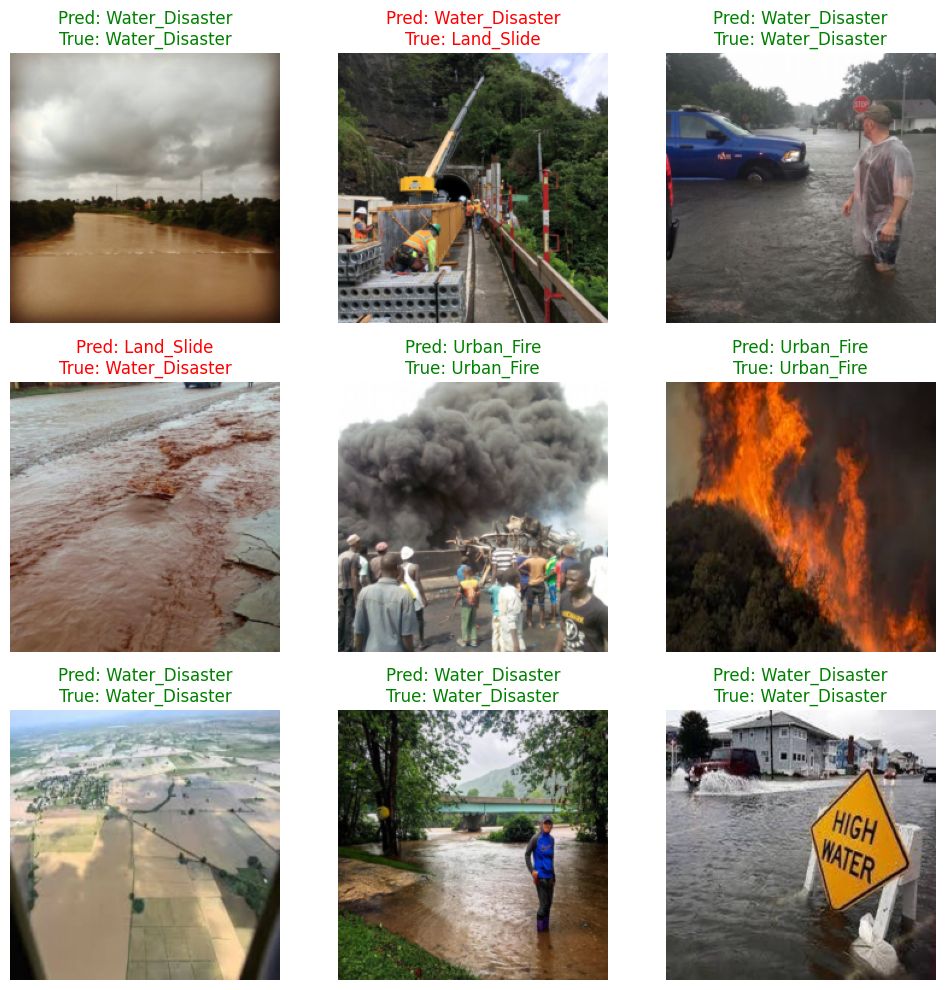

In [28]:
def test_demo(model: nn.Module, 
              dataloader: DataLoader, 
              class_names: list, 
              device: torch.device = 'cpu', 
              num_samples: int = 9):
    import torchvision.transforms.functional as TF

    model.eval()
    model.to(device)

    with torch.no_grad():
        all_images = []
        all_labels = []
        all_preds = []

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_images.extend(images.cpu())
            all_labels.extend(labels.cpu())
            all_preds.extend(preds.cpu())

        if not all_images:
            print("No images found in the dataloader.")
            return

        num_available = len(all_images)
        indices = random.sample(range(num_available), min(num_samples, num_available))

        plt.figure(figsize=(10, 10))
        for i, idx in enumerate(indices, start=1):
            img = all_images[idx]
            label = all_labels[idx].item()
            pred = all_preds[idx].item()

            img = TF.to_pil_image(img)

            plt.subplot(3, 3, i)
            plt.imshow(img)
            color = 'green' if pred == label else 'red'
            plt.title(f"Pred: {list(class_names)[pred]}\nTrue: {list(class_names)[label]}", color=color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

test_demo(model=scratchModel,
          dataloader=test_loader,
          class_names=class_names,
          device=device,)

# 11. CNN Scrath Model Evaluation

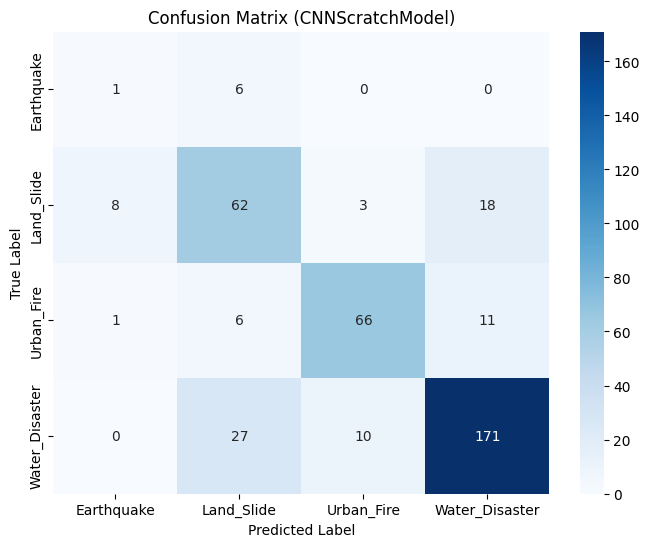

In [29]:
def plot_confusion_matrix(model: nn.Module, 
                          dataloader: DataLoader, 
                          class_names: list, 
                          device: torch.device = 'cpu'):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model.__class__.__name__})")
    plt.show()

scratch_confusion_matrix_plot = plot_confusion_matrix(model=scratchModel,
                      dataloader=test_loader,
                      class_names=class_names,
                      device=device)

scratch_confusion_matrix_plot

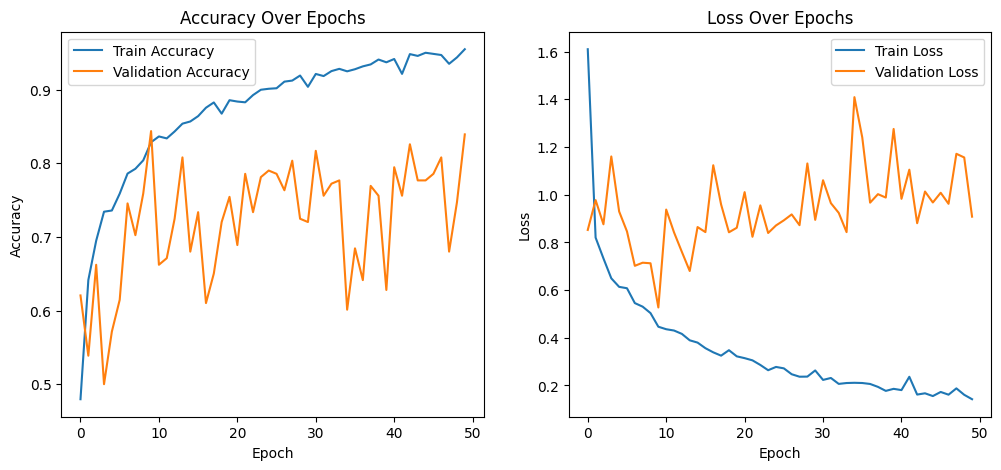

In [30]:
def plot_accuracy_loss(train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list):
    plt.figure(figsize=(12, 5))

    val_loss_list = [tensor.cpu().item() for tensor in val_loss_list]
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy_list, label='Train Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    
    plt.show()

scratch_accuracy_loss_plot = plot_accuracy_loss(train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list)

scratch_accuracy_loss_plot

# 12. Transfer Learning using MobileNetV2

## 12.1 Freeze Layers

In [31]:
import torchvision.models as models

mobilenetModel = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
in_features = mobilenetModel.classifier[1].in_features
mobilenetModel.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features=in_features,
              out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,
              out_features=NUM_CLASSES)
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 114MB/s] 


In [32]:
for param in mobilenetModel.parameters():
    param.requires_grad = False

for param in mobilenetModel.classifier.parameters():
    param.requires_grad = True

In [33]:
summary(mobilenetModel, input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [32, 4]                   --
├─Sequential: 1-1                                  [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                   [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                            [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        (64)
│    │    └─ReLU6: 3-3                             [32, 32, 112, 112]        --
│    └─InvertedResidual: 2-2                       [32, 16, 112, 112]        --
│    │    └─Sequential: 3-4                        [32, 16, 112, 112]        (896)
│    └─InvertedResidual: 2-3                       [32, 24, 56, 56]          --
│    │    └─Sequential: 3-5                        [32, 24, 56, 56]          (5,136)
│    └─InvertedResidual: 2-4                       [32, 24, 56, 56]          --
│    │    └─Sequential

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetModel.parameters(), lr=1e-5)

In [35]:
epochs = 20

train_accuracy_list, val_accuracy_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}\n-------')
    train_acc, train_loss = train_loop(model=mobilenetModel,
               dataloader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               num_classes=NUM_CLASSES,
               device=device)
    val_acc, val_loss = validate_model(model=mobilenetModel,
                   dataloader=val_loader,
                   loss_fn=loss_fn,
                   num_classes=NUM_CLASSES,
                   device=device)
    print()
    train_accuracy_list.append(train_acc)
    val_accuracy_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

Epoch: 1
-------
Train loss: 1.38319 | Train Accuracy: 0.28 | Train Precision: 0.40 | Train Recall: 0.28 | Train F1-Score: 0.30
Validation loss: 1.37152 | Validation Accuracy: 0.31 | Validation Precision: 0.73 | Validation Recall: 0.31 | Validation F1-Score: 0.39

Epoch: 2
-------
Train loss: 1.34311 | Train Accuracy: 0.35 | Train Precision: 0.50 | Train Recall: 0.35 | Train F1-Score: 0.39
Validation loss: 1.33749 | Validation Accuracy: 0.32 | Validation Precision: 0.67 | Validation Recall: 0.32 | Validation F1-Score: 0.42

Epoch: 3
-------
Train loss: 1.30585 | Train Accuracy: 0.42 | Train Precision: 0.62 | Train Recall: 0.42 | Train F1-Score: 0.46
Validation loss: 1.29309 | Validation Accuracy: 0.40 | Validation Precision: 0.80 | Validation Recall: 0.40 | Validation F1-Score: 0.51

Epoch: 4
-------
Train loss: 1.25981 | Train Accuracy: 0.47 | Train Precision: 0.67 | Train Recall: 0.47 | Train F1-Score: 0.52
Validation loss: 1.23663 | Validation Accuracy: 0.47 | Validation Precision: 

In [36]:
mobileNet_freeze_test_loss, mobileNet_freeze_test_accuracy, mobileNet_freeze_test_precision, mobileNet_freeze_test_recall, mobileNet_freeze_test_f1score = test_model(model=mobilenetModel, 
                                                                                 dataloader=test_loader, 
                                                                                 loss_fn=loss_fn, 
                                                                                 num_classes=NUM_CLASSES, 
                                                                                 device=device)

mobileNet_freeze_test_loss, mobileNet_freeze_test_accuracy, mobileNet_freeze_test_precision, mobileNet_freeze_test_recall, mobileNet_freeze_test_f1score

Test loss: 0.59774 | Test Accuracy: 0.85 | Test Precision: 0.84 | Test Recall: 0.85 | Test F1-Score: 0.84


(tensor(0.5977, device='cuda:0'),
 0.8509615384615384,
 0.8406912684440613,
 0.8509615384615384,
 0.8388301134109497)

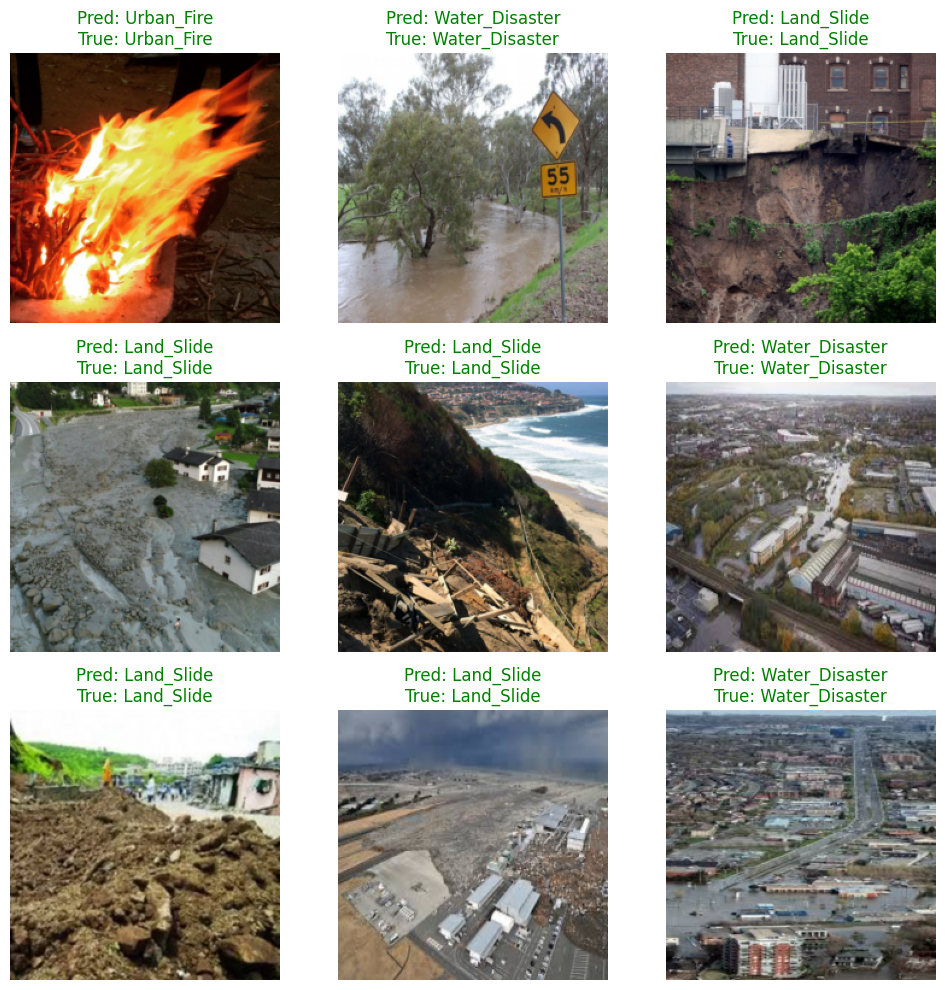

In [37]:
test_demo(model=mobilenetModel,
          dataloader=test_loader,
          class_names=class_names,
          device=device,)

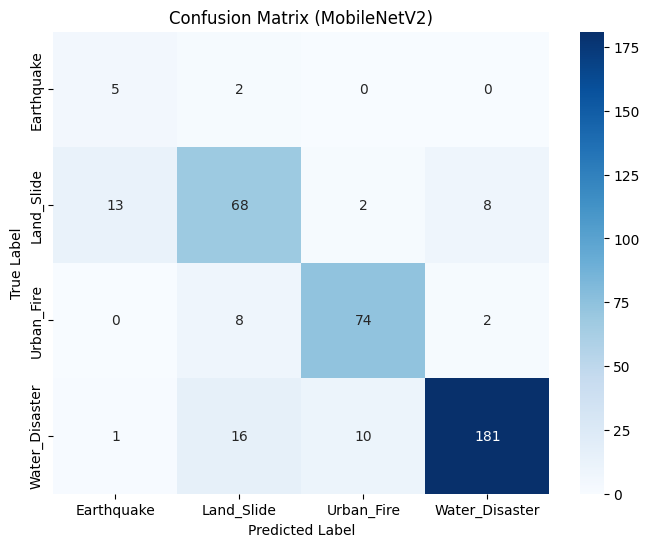

In [38]:
mobileNet_confusion_matrix_plot = plot_confusion_matrix(model=mobilenetModel,
                      dataloader=test_loader,
                      class_names=class_names,
                      device=device)

mobileNet_confusion_matrix_plot

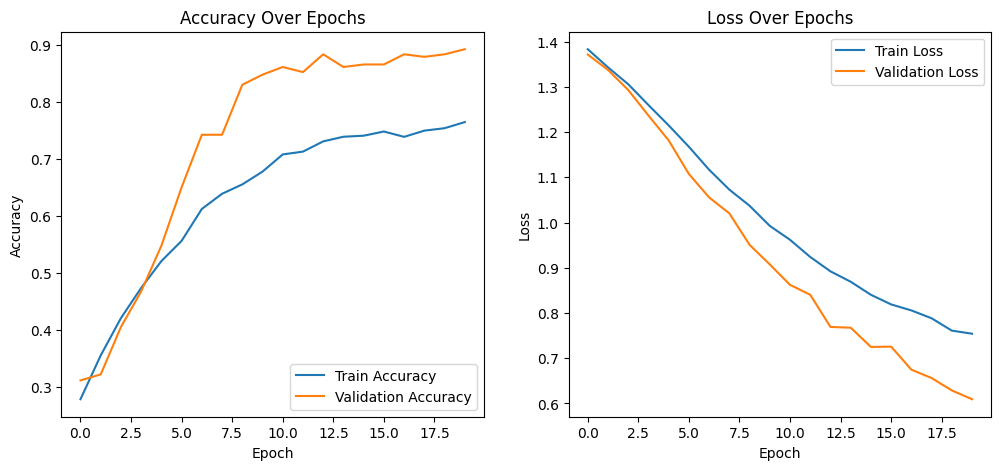

In [39]:
mobileNet_accuracy_loss_plot = plot_accuracy_loss(train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list)

mobileNet_accuracy_loss_plot

## 12.2 Unfreeze Layers

In [40]:
import torchvision.models as models

mobilenetModel = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
in_features = mobilenetModel.classifier[1].in_features
mobilenetModel.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features=in_features,
              out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,
              out_features=NUM_CLASSES)
)

In [41]:
for param in mobilenetModel.parameters():
    param.requires_grad = True

for param in mobilenetModel.classifier.parameters():
    param.requires_grad = True

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetModel.parameters(), lr=1e-5)

In [43]:
epochs = 20

train_accuracy_list, val_accuracy_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}\n-------')
    train_acc, train_loss = train_loop(model=mobilenetModel,
               dataloader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               num_classes=NUM_CLASSES,
               device=device)
    val_acc, val_loss = validate_model(model=mobilenetModel,
                   dataloader=val_loader,
                   loss_fn=loss_fn,
                   num_classes=NUM_CLASSES,
                   device=device)
    print()
    train_accuracy_list.append(train_acc)
    val_accuracy_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

Epoch: 1
-------
Train loss: 1.27313 | Train Accuracy: 0.44 | Train Precision: 0.70 | Train Recall: 0.44 | Train F1-Score: 0.50
Validation loss: 1.15535 | Validation Accuracy: 0.63 | Validation Precision: 0.70 | Validation Recall: 0.63 | Validation F1-Score: 0.60

Epoch: 2
-------
Train loss: 0.96179 | Train Accuracy: 0.71 | Train Precision: 0.80 | Train Recall: 0.71 | Train F1-Score: 0.72
Validation loss: 0.74856 | Validation Accuracy: 0.84 | Validation Precision: 0.82 | Validation Recall: 0.84 | Validation F1-Score: 0.83

Epoch: 3
-------
Train loss: 0.69678 | Train Accuracy: 0.80 | Train Precision: 0.84 | Train Recall: 0.80 | Train F1-Score: 0.80
Validation loss: 0.48033 | Validation Accuracy: 0.89 | Validation Precision: 0.88 | Validation Recall: 0.89 | Validation F1-Score: 0.88

Epoch: 4
-------
Train loss: 0.53400 | Train Accuracy: 0.84 | Train Precision: 0.86 | Train Recall: 0.84 | Train F1-Score: 0.84
Validation loss: 0.38355 | Validation Accuracy: 0.91 | Validation Precision: 

In [44]:
mobileNet_unfreeze_test_loss, mobileNet_unfreeze_test_accuracy, mobileNet_unfreeze_test_precision, mobileNet_unfreeze_test_recall, mobileNet_unfreeze_test_f1score = test_model(model=mobilenetModel, 
                                                                                 dataloader=test_loader, 
                                                                                 loss_fn=loss_fn, 
                                                                                 num_classes=NUM_CLASSES, 
                                                                                 device=device)

mobileNet_unfreeze_test_loss, mobileNet_unfreeze_test_accuracy, mobileNet_unfreeze_test_precision, mobileNet_unfreeze_test_recall, mobileNet_unfreeze_test_f1score

Test loss: 0.26405 | Test Accuracy: 0.91 | Test Precision: 0.91 | Test Recall: 0.91 | Test F1-Score: 0.90


(tensor(0.2640, device='cuda:0'),
 0.9086538461538461,
 0.9059264338933505,
 0.9086538461538461,
 0.9031003942856421)

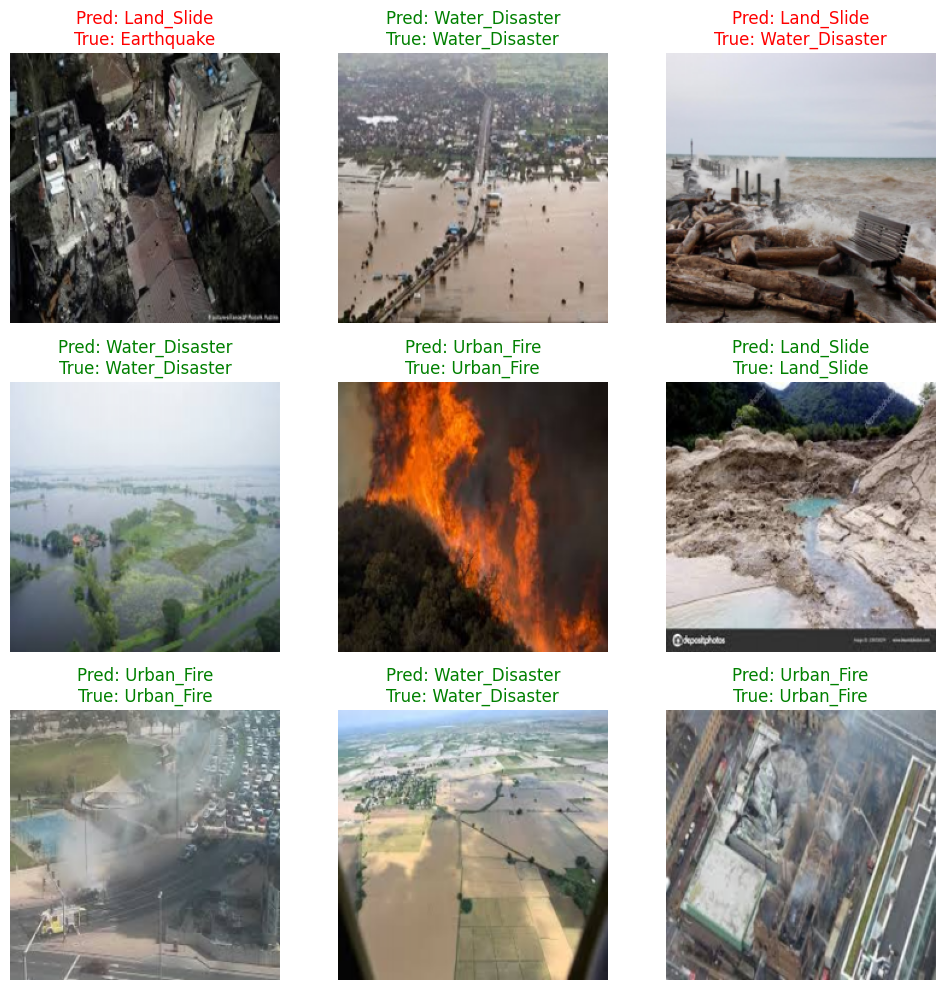

In [45]:
test_demo(model=mobilenetModel,
          dataloader=test_loader,
          class_names=class_names,
          device=device,)

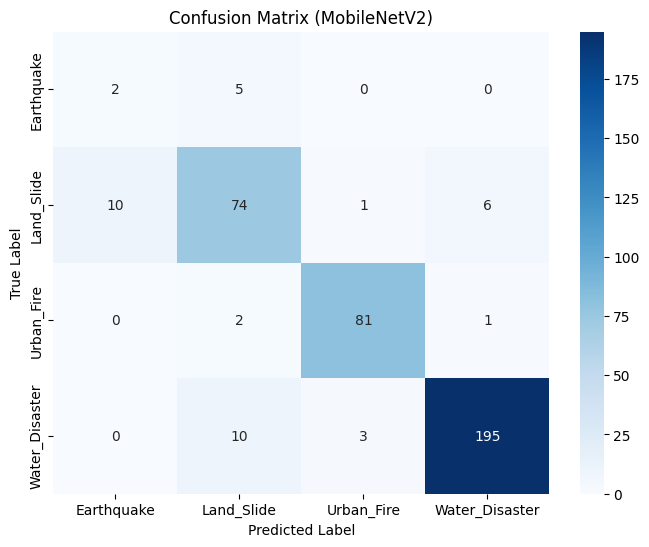

In [46]:
mobileNet_confusion_matrix_plot = plot_confusion_matrix(model=mobilenetModel,
                      dataloader=test_loader,
                      class_names=class_names,
                      device=device)

mobileNet_confusion_matrix_plot

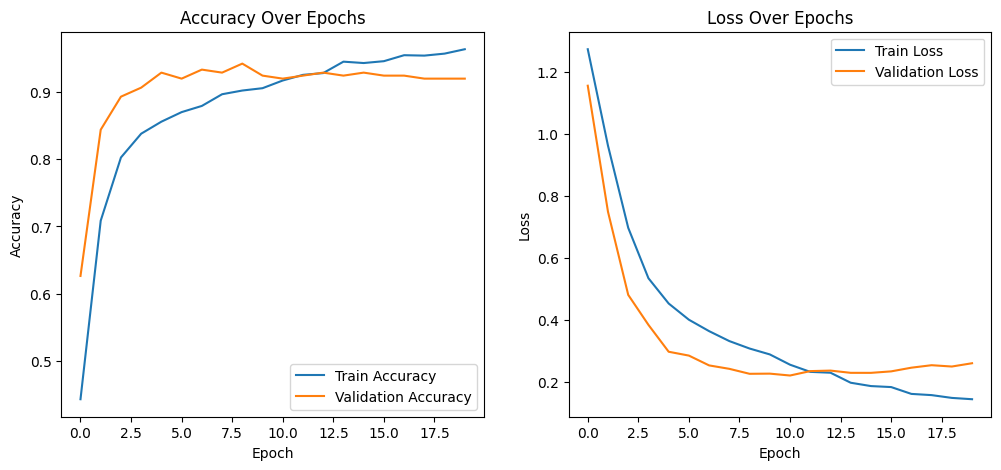

In [47]:
mobileNet_accuracy_loss_plot = plot_accuracy_loss(train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list)

mobileNet_accuracy_loss_plot

# 13. Model Comparison

In [48]:
comparison_model = {
    'Model': ['Scratch Model', 'MobileNetV2 (Unfreeze)', 'MobileNetV2 (Freeze)'],
    'Loss': [scratch_test_loss.cpu().item(), mobileNet_freeze_test_loss.cpu().item(), mobileNet_unfreeze_test_loss.cpu().item()],
    'Accuracy': [scratch_test_accuracy, mobileNet_freeze_test_accuracy, mobileNet_unfreeze_test_accuracy],
    'Precision': [scratch_test_precision, mobileNet_freeze_test_precision, mobileNet_unfreeze_test_precision],
    'Recall': [scratch_test_recall, mobileNet_freeze_test_recall, mobileNet_unfreeze_test_recall],
    'F1_Score': [scratch_test_f1score, mobileNet_freeze_test_f1score, mobileNet_unfreeze_test_f1score],
}

comparison_model_df = pd.DataFrame(comparison_model)

print(comparison_model_df)

                    Model      Loss  Accuracy  Precision    Recall  F1_Score
0           Scratch Model  1.086758  0.783654   0.788689  0.783654  0.777969
1  MobileNetV2 (Unfreeze)  0.597743  0.850962   0.840691  0.850962  0.838830
2    MobileNetV2 (Freeze)  0.264046  0.908654   0.905926  0.908654  0.903100


In [50]:
scratchModel_filename = 'scratch-model.pth'
mobilenetModel_filename = 'custom-mobilenet-model.pth'

torch.save(scratchModel.state_dict(), scratchModel_filename)
torch.save(mobilenetModel.state_dict(), mobilenetModel_filename)

print(f'Pytorch model \'{scratchModel.__class__.__name__}\' state saved to {scratchModel_filename}')
print(f'Pytorch model \'{mobilenetModel.__class__.__name__}\' state saved to {mobilenetModel_filename}')

Pytorch model 'CNNScratchModel' state saved to scratch-model.pth
Pytorch model 'MobileNetV2' state saved to custom-mobilenet-model.pth
